## Model Evaluation Workflow

This notebook evaluates two relation extraction models using a sample dataset (`Test.BioC.JSON`) and a filtered dataset (`filtered_data.csv`). 

### **Workflow Overview:**
1. **Load the Sample Data**  
   - The dataset is preprocessed and displayed in a DataFrame.

2. **User Input for Document Selection**  
   - The user selects one or multiple `Document ID`s from the dataset.

3. **Evaluate Both Models**  
   - Once a `Document ID` is selected, the code evaluates both models on that specific ID.

4. **Generate Results:**
   - **Summary Report:** Includes accuracy, precision, recall, F1 score, and silhouette score.
   - **Final Relation Extraction Results:** Displays extracted relations with predicted labels.

5. **Comparison & Visualization**
   - A comparison table is generated to contrast model performances.
   - Graphs are plotted for a visual comparison of key evaluation metrics.

This approach ensures an interactive and comprehensive evaluation of relation extraction models.


In [1]:
import pandas as pd 

csv_file_path = "filtered_data.csv"
df_loaded = pd.read_csv(csv_file_path)
df_loaded.head()

,Document ID,Passage,Entity 1,Relation,Entity 2
0,15036754,Organophosphate-induced convulsions and preven...,24408,Negative_Correlation,D016291
1,19531695,Delirium in a patient with toxic flecainide pl...,D012964,Association,D003693
2,18439803,Acute effects of N-(2-propylpentanoyl)urea on ...,D014635,Negative_Correlation,D010862
3,16731636,Enhanced isoproterenol-induced cardiac hypertr...,D006332,Association,24925
4,16428827,The choline acetyltransferase (ChAT) activator...,C004742,Negative_Correlation,D000647


## 1. Baseline Model on Test Dataset

In [2]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix, silhouette_score
from scipy.optimize import linear_sum_assignment

def load_csv(file_path):
    return pd.read_csv(file_path)

class RelationEncoder(torch.nn.Module):
    def __init__(self, pretrained_model_name='bert-base-uncased'):
        super(RelationEncoder, self).__init__()
        print(f"\nInitializing Relation Encoder Model with {pretrained_model_name}...")
        self.bert = BertModel.from_pretrained(pretrained_model_name)
        self.fc = torch.nn.Linear(self.bert.config.hidden_size, 128)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls = outputs.last_hidden_state[:, 0, :]
        emb = self.fc(cls)
        emb = torch.nn.functional.normalize(emb, p=2, dim=1)
        return emb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("\nLoading pre-trained model...")
model = RelationEncoder().to(device)
model.load_state_dict(torch.load("baseline_model.pth", map_location=device), strict=False)
model.eval()
print("Model loaded successfully!\n")

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Load test dataset
file_path = "filtered_data.csv"  # Update with the correct file path
df = load_csv(file_path)

input_ids = input("\nEnter Document IDs Separated By Commas: ").split(',')
input_ids = [id.strip() for id in input_ids]  # Clean input

df = df[df["Document ID"].astype(str).isin(input_ids)]

if df.empty:
    print("\nNo matching data found for the given Document IDs.")
else:
    relation_texts = df[["Entity 1", "Relation", "Entity 2"]].apply(lambda x: f"{x[0]} - {x[1]} - {x[2]}", axis=1).tolist()
    true_labels = df["Relation"].tolist()
    doc_ids = df["Document ID"].tolist()

    # Extract embeddings
    print("\nComputing embeddings...")
    def extract_embeddings(model, texts, tokenizer):
        model.eval()
        embeddings = []
        with torch.no_grad():
            inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
            inputs = {k: v.to(device) for k, v in inputs.items()}
            emb = model(inputs["input_ids"], inputs["attention_mask"])
            embeddings.append(emb.cpu().numpy())
        return np.concatenate(embeddings, axis=0)
    
    embeddings = extract_embeddings(model, relation_texts, tokenizer)
    print(f"Computed embeddings with shape: {embeddings.shape}\n")

    # Perform Clustering (K-Means)
    num_clusters = len(set(true_labels))
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    predicted_labels = kmeans.fit_predict(embeddings)

    # Map Cluster Labels to True Labels
    def map_cluster_labels(true_labels, predicted_labels):
        label_names = list(set(true_labels))
        true_numeric = [label_names.index(x) for x in true_labels]
        cm = confusion_matrix(true_numeric, predicted_labels)
        row_ind, col_ind = linear_sum_assignment(-cm)
        mapping = {col: row for row, col in zip(row_ind, col_ind)}
        mapped_predicted = [mapping[p] for p in predicted_labels]
        return [label_names[x] for x in mapped_predicted]
    
    mapped_predicted_labels = map_cluster_labels(true_labels, predicted_labels)
    
    # Compute Summary Statistics
    correct_predictions = sum(1 for t, p in zip(true_labels, mapped_predicted_labels) if t == p)
    total_relations = len(true_labels)
    accuracy = correct_predictions / total_relations
    precision = precision_score(true_labels, mapped_predicted_labels, average='weighted')
    recall = recall_score(true_labels, mapped_predicted_labels, average='weighted')
    f1 = f1_score(true_labels, mapped_predicted_labels, average='weighted')
    silhouette = silhouette_score(embeddings, predicted_labels)
    
    # Prepare dictionary with proper metric names using the computed variables
    metrics_model1 = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Silhouette': silhouette,
    }
    
    print('-----------------------------------------------------')
    print("\nSummary Report:")
    print(f"Total Relations Processed: {total_relations}")
    print(f"Correctly Predicted Relations: {correct_predictions}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Silhouette Score: {silhouette:.4f}\n")
    print('-----------------------------------------------------')
    
    # Print Results
    print("\nFinal Relation Extraction Results:")
    for doc_id, text, t_label, p_label in zip(doc_ids, relation_texts, true_labels, mapped_predicted_labels):
        status = "Correct" if t_label == p_label else "Incorrect"
        print(f"\nDocument ID: {doc_id}\nRelation: {text}\nTrue Label: {t_label}\nPredicted Label: {p_label}\nStatus: {status}")


Loading pre-trained model...

Initializing Relation Encoder Model with bert-base-uncased...


/Users/kashifmoin/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exac

Model loaded successfully!


Enter Document IDs Separated By Commas: 16731636

Computing embeddings...
Computed embeddings with shape: (22, 128)

-----------------------------------------------------

Summary Report:
Total Relations Processed: 22
Correctly Predicted Relations: 16
Accuracy: 0.7273
Precision: 0.8485
Recall: 0.7273
F1 Score: 0.7688
Silhouette Score: 0.6016

-----------------------------------------------------

Final Relation Extraction Results:

Document ID: 16731636
Relation: D006332 - Association - 24925
True Label: Association
Predicted Label: Association
Status: Correct

Document ID: 16731636
Relation: 24925 - Positive_Correlation - D007545
True Label: Positive_Correlation
Predicted Label: Positive_Correlation
Status: Correct

Document ID: 16731636
Relation: D006332 - Association - 25238
True Label: Association
Predicted Label: Association
Status: Correct

Document ID: 16731636
Relation: D007545 - Positive_Correlation - D006332
True Label: Positive_Correlation
Predic

## 2. Trained Model on Test Dataset

In [3]:
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from sklearn.metrics import (
    confusion_matrix, classification_report, silhouette_score, 
    calinski_harabasz_score, precision_score, recall_score, f1_score
)
from sklearn.decomposition import PCA
from scipy.optimize import linear_sum_assignment
from sklearn.manifold import TSNE
import umap

def load_csv(file_path):
    """Load a CSV file containing document relations."""
    print(f"Loading CSV file: {file_path}")
    data = pd.read_csv(file_path)
    print(f"Successfully loaded {file_path}, containing {len(data)} records.\n")
    return data


input_ids = [id.strip() for id in input_ids]  # Clean input

# Load dataset
file_path = "filtered_data.csv"  # Ensure correct file path
df = load_csv(file_path)

# Filter dataset based on input IDs
df = df[df["Document ID"].astype(str).isin(input_ids)]

if df.empty:
    print("No matching data found for the given Document IDs.")
    exit()

relation_texts = df[["Entity 1", "Relation", "Entity 2"]].apply(lambda x: f"{x[0]} - {x[1]} - {x[2]}", axis=1).tolist()
true_labels = df["Relation"].tolist()
doc_ids = df["Document ID"].tolist()

class RelationExtractionModel(torch.nn.Module):
    def __init__(self, bert_model_name="microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract", embedding_dim=768):
        super(RelationExtractionModel, self).__init__()
        print(f"Initializing Relation Extraction Model with {bert_model_name}")
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = torch.nn.Dropout(p=0.1)
        self.fc = torch.nn.Linear(embedding_dim, embedding_dim)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.pooler_output
        cls_output = self.dropout(cls_output)
        relation_embedding = self.fc(cls_output)
        return relation_embedding

print("\nLoading pre-trained model...")
model = RelationExtractionModel()
model.load_state_dict(torch.load("trained_relation_extraction_model.pth", map_location=torch.device("cpu")), strict=False)
model.eval()
print("Model loaded successfully!\n")

tokenizer = BertTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract")

def get_embedding(text, tokenizer, model):
    """Compute the embedding for a given relation text using the model."""
    try:
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            embedding = model(inputs["input_ids"], inputs["attention_mask"])
        return embedding.squeeze(0).cpu().numpy()
    except Exception as e:
        print(f"Error computing embedding for: '{text}'\nError: {e}")
        return None

print("Computing embeddings for extracted relations...")
embeddings = [get_embedding(text, tokenizer, model) for text in relation_texts]
embeddings = np.array([emb for emb in embeddings if emb is not None])

if embeddings.shape[0] == 0:
    print("No embeddings computed. Exiting.")
    exit()

print(f"Computed embeddings with shape: {embeddings.shape}\n")


num_clusters = len(set(true_labels))
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
predicted_labels = kmeans.fit_predict(embeddings)


def map_cluster_labels(true_labels, predicted_labels):
    label_names = list(set(true_labels))
    true_numeric = [label_names.index(x) for x in true_labels]
    cm = confusion_matrix(true_numeric, predicted_labels)
    row_ind, col_ind = linear_sum_assignment(-cm)
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    mapped_predicted = [mapping[p] for p in predicted_labels]
    return [label_names[x] for x in mapped_predicted]

mapped_predicted_labels = map_cluster_labels(true_labels, predicted_labels)

# Compute Summary Statistics
precision = precision_score(true_labels, mapped_predicted_labels, average='weighted', zero_division=0)
recall = recall_score(true_labels, mapped_predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(true_labels, mapped_predicted_labels, average='weighted', zero_division=0)
silhouette = silhouette_score(embeddings, predicted_labels) if len(set(predicted_labels)) > 1 else 0

correct_predictions = sum(1 for t, p in zip(true_labels, mapped_predicted_labels) if t == p)
accuracy = correct_predictions / len(true_labels)

metrics_model2 = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Silhouette': silhouette,
}

# Print Summary Report
print('-----------------------------------------------------')
print("\nSummary Report:")
print(f"Total Relations Processed: {len(true_labels)}")
print(f"Correctly Predicted Relations: {correct_predictions}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Silhouette Score: {silhouette:.4f}\n")
print('-----------------------------------------------------')

print("\nFinal Relation Extraction Results:")
for doc_id, text, t_label, p_label in zip(doc_ids, relation_texts, true_labels, mapped_predicted_labels):
    status = "Correct" if t_label == p_label else "Incorrect"
    print(f"\nDocument ID: {doc_id}\nRelation: {text}\nTrue Label: {t_label}\nPredicted Label: {p_label}\nStatus: {status}")


Loading CSV file: filtered_data.csv
Successfully loaded filtered_data.csv, containing 234 records.


Loading pre-trained model...
Initializing Relation Extraction Model with microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract


/Users/kashifmoin/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/kashifmoin/anaconda3/lib/python3.11/site-packages/transformers/modeling_utils.py:446: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowliste

Model loaded successfully!



Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Computing embeddings for extracted relations...
Computed embeddings with shape: (22, 768)

-----------------------------------------------------

Summary Report:
Total Relations Processed: 22
Correctly Predicted Relations: 22
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Silhouette Score: 0.9540

-----------------------------------------------------

Final Relation Extraction Results:

Document ID: 16731636
Relation: D006332 - Association - 24925
True Label: Association
Predicted Label: Association
Status: Correct

Document ID: 16731636
Relation: 24925 - Positive_Correlation - D007545
True Label: Positive_Correlation
Predicted Label: Positive_Correlation
Status: Correct

Document ID: 16731636
Relation: D006332 - Association - 25238
True Label: Association
Predicted Label: Association
Status: Correct

Document ID: 16731636
Relation: D007545 - Positive_Correlation - D006332
True Label: Positive_Correlation
Predicted Label: Positive_Correlation
Status: Correct

Docume

## Model Comparison

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

"""
created a pandas DataFrame to compare evaluation metrics between two models:
1. Baseline Model
2. HNM Model

Each model's metrics are stored in dictionaries (metrics_model1 and metrics_model2). 
The DataFrame is constructed such that each row represents one model and each column 
represents a specific evaluation metric (e.g., accuracy, precision, recall). This table 
provides a convenient overview for direct comparison of the models' performance.
"""

df = pd.DataFrame([metrics_model1, metrics_model2], index=[f"Baseline Model {input_ids}", f"HNM Model {input_ids}"])
df

,Accuracy,Precision,Recall,F1 Score,Silhouette
Baseline Model ['16731636'],0.727273,0.848485,0.727273,0.768831,0.601572
HNM Model ['16731636'],1.000000,1.000000,1.000000,1.000000,0.954010


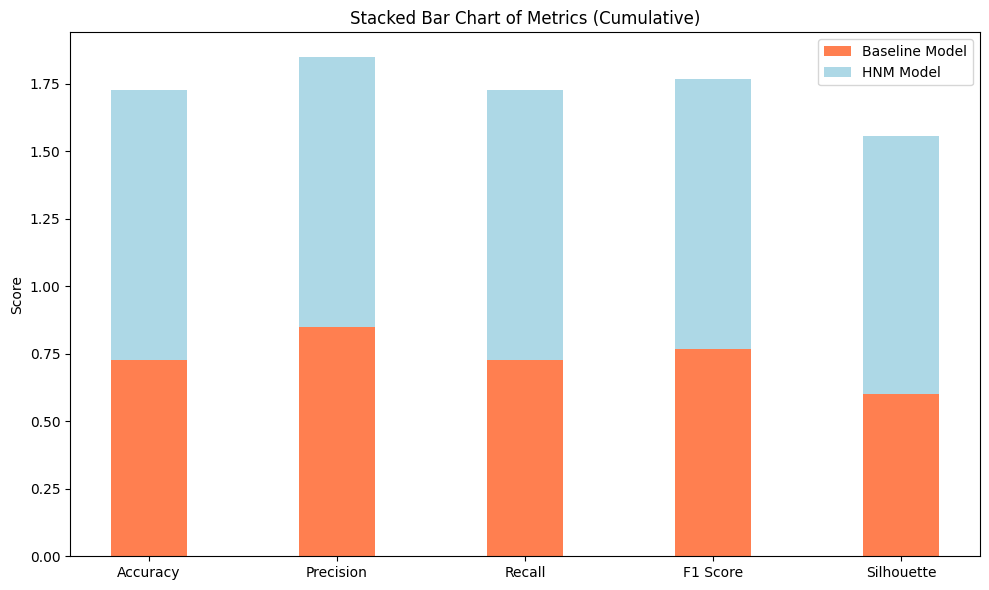

In [5]:
"""
created a stacked bar chart to compare evaluation metrics for two models:
1. Baseline Model
2. HNM Model

For each evaluation metric, a bar is drawn where the Baseline Model's value is plotted first,
and the HNM Model's value is stacked on top. The cumulative height of each bar represents
the combined score for that metric. The x-axis shows the metric names, while the y-axis
indicates the scores. This visualization provides a clear comparison of how each model
contributes to the overall metric scores.
"""

categories = list(metrics_model1.keys())
x = np.arange(len(categories))
width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))
indices = np.arange(len(categories))
model1_values = np.array([metrics_model1[m] for m in categories])
model2_values = np.array([metrics_model2[m] for m in categories])
# Stacked bars: Model 2 is drawn on top of Model 1
ax.bar(indices, model1_values, width=0.4, label="Baseline Model", color="coral")
ax.bar(indices, model2_values, width=0.4, label="HNM Model", color="lightblue", bottom=model1_values)
ax.set_xticks(indices)
ax.set_xticklabels(categories)
ax.set_title("Stacked Bar Chart of Metrics (Cumulative)")
ax.set_ylabel("Score")
ax.legend()
plt.tight_layout()
plt.show()

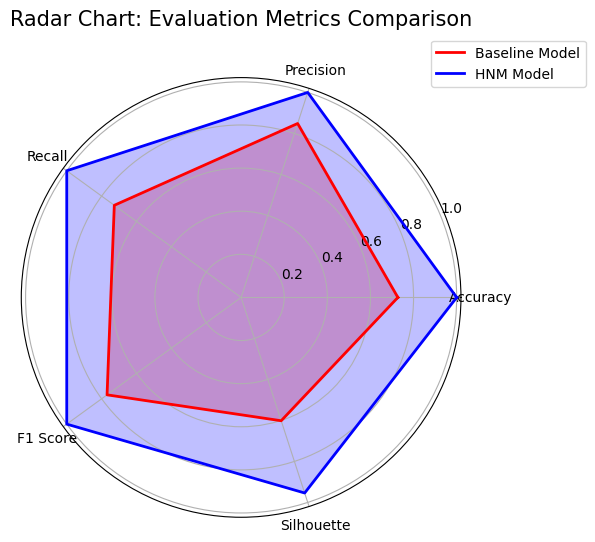

In [6]:
"""
This creates a radar chart to compare evaluation metrics for two models:
1.⁠ ⁠Baseline Model
2.⁠ ⁠HNM Model

The radar chart plots different metrics on separate axes that radiate from the center.
Each axis represents a specific evaluation metric (like accuracy, precision, etc.).
The distance from the center along each axis corresponds to the value of that metric.
By connecting the points for each model, the chart forms a closed polygon, making it
easy to visually compare the performance of the two models across all metrics.
"""

def create_radar_chart(metrics_dict):
    categories = list(metrics_dict.keys())
    values = list(metrics_dict.values())
    # Close the circle by repeating the first value and angle
    values += values[:1]
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]
    return angles, values, categories

angles1, values1, categories = create_radar_chart(metrics_model1)
angles2, values2, _ = create_radar_chart(metrics_model2)

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.plot(angles1, values1, color='r', linewidth=2, label="Baseline Model")
ax.fill(angles1, values1, color='r', alpha=0.25)
ax.plot(angles2, values2, color='b', linewidth=2, label="HNM Model")
ax.fill(angles2, values2, color='b', alpha=0.25)
ax.set_thetagrids(np.degrees(angles1[:-1]), categories)
ax.set_title("Radar Chart: Evaluation Metrics Comparison", size=15, y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()